# Default payment by different education levels
## 1. Introduction 
* According to an article published on Investopedia by James Chen, default payment is generally defined as a failure for borrowers to make required repayments on a debt for businesses, individuals or lenders in general. Default payment may severely impact different aspects in our financial situation in the future such as credit score and the ability to borrow money in the future. It is also argued that default payment is also linked with education level. Based on a research study report by Aalto University in Finland, researchers argued that default payments are more prevalent among those who have a lower educational background. 
* In this research project, we will be assessing whether the claim above is true by performing hypothesis testing on the `default of credit card clients.xls` dataset where information was based on cases of customer’s credit card in Taiwan. Data was collected by the Department of Information Management at Chung Hua University and the Department of Civil Engineering at Tangkam University both located in Taiwan. Our goal for this project is to examine whether there is a difference in the proportion of people with a university education background who have a default payment on their credit cards and the proportion of those who graduated from high school experiencing credit card’s default payment. The variables being studied are `EDUCATION` and `default payment next month`. 

## 2. Methods:
* The data collected offers a comprehensive overview of 23 variables based on whether they have default payments. With these variables we are able to study whether these variables are correlated with a person having default payments. For this study, we will determine whether education level has an effect on the likelihood of default, specifically between high school graduates and university graduates. The distinct categories that expressed in the data allow us to clearly see the difference of each group within the sample.
* Our hypotheses will be:  $𝐻_{0}:𝑝1−𝑝2=0$  and  $𝐻_{1}:𝑝1−𝑝2≠0$  (we are treating groups of high school education level and university education level as two independent samples) . Looking at the observed difference we calculated above, we are likely to reject our  𝐻0  in favor of  𝐻1 . However, we still need to make sure that our finding is statistically significant. Therefore, we will perform a difference of proportions hypothesis test. We can then create a bootstrap distribution and calculate confidence intervals for the true mean difference between the two variables.


## 3. Loading and cleaning data: 
### Loading data:
* We begin loading necessary packages for analysis purposes

In [ ]:
library(tidyverse)
library(readxl)
install.packages("rio")
library(rio)
install.packages("infer")
library(infer)
install.packages("reshape2")
library(reshape2)
install.packages("broom")
library(broom)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



* Next, we load in our dataset

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
credit_card_data <- rio::import(file = url, skip =1)

head(credit_card_data)
nrow(credit_card_data)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,6,50000,1,1,2,37,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


[1] 30000

### Cleaning and wrangling data 

* We will also perform data cleaning. First, we picked out the values that would be necessary for our analysis, in this case `EDUCATION` and `default payment next month`. After that, we will rewrite the values of these variables for easier intepretation. Lastly, we filter out the values of interest of the `EDUCATION`  variable. 

In [3]:
credit_card_clean <- credit_card_data %>%
                     mutate(education_level=as.character(`EDUCATION`)) %>%
                     mutate(default=as.character(`default payment next month`)) %>%
                     select(education_level, default) %>% 
                     mutate(education_level = replace(education_level, education_level == "2", "University"),
                            default = replace(default, default== "1", "Yes")) %>%
                     mutate(education_level = replace(education_level, education_level == "3", "High_School"),
                            default = replace(default, default== "0", "No"))%>%
                    filter(education_level == 'University' | education_level == 'High_School')%>%
mutate(education_level = as_factor(education_level),
       default = as_factor(default))
head(credit_card_clean)
table(credit_card_clean)

,education_level,default
,<fct>,<fct>
1,University,Yes
2,University,Yes
3,University,No
4,University,No
5,University,No
6,University,No


               default
education_level   Yes    No
    University   3330 10700
    High_School  1237  3680

## 4. Methods:
* The data collected offers a comprehensive overview of 23 variables based on whether they have default payments. With these variables we are able to study whether these variables are correlated with a person having default payments. For this study, we will determine whether education level has an effect on the likelihood of default, specifically between high school graduates and university graduates. The distinct categories expressed in the data allow us to clearly see the difference of each group within the sample. 

* Our hypotheses will be:  $H_0: p_1 - p_2 = 0$ and $H_1: p_1 - p_2 \neq 0$    (we are treating groups of high school education level and university education level as two independent samples) . Looking at the observed difference we calculated above, we are likely to reject our  $𝐻_0$  in favor of  $𝐻_1$ . However, we still need to make sure that our finding is statistically significant. Therefore, we will perform a difference of proportions hypothesis test. We can then create a bootstrap distribution and calculate confidence intervals for the true mean difference between the two variables.

* We will be calculating results using two different hypothesis testing methods: bootstrapping and and asymptotics. After that, we will assess whether these two methods return similar values 

## 5. Results:
### Hypothesis Testing using Asymtotics Methods:


In [4]:
default_summary <-
    credit_card_clean %>% 
    group_by(education_level) %>% 
    summarise(n = n(), 
              p_hat = mean(default == "Yes"),  
             `.groups` = "drop") %>% 
    pivot_wider(names_from = education_level, values_from = c(n, p_hat))%>%
     mutate(prop_diff = p_hat_University - p_hat_High_School)
default_summary

n_University,n_High_School,p_hat_University,p_hat_High_School,prop_diff
<int>,<int>,<dbl>,<dbl>,<dbl>
14030,4917,0.2373485,0.2515762,-0.01422763


In [5]:
default_prop_test<-  
    tidy(
        prop.test(
        x = c(default_summary$n_University* default_summary$p_hat_University,
              default_summary$n_High_School * default_summary$p_hat_High_School), # the number of successes,
        n = c(default_summary$n_University,
              default_summary$n_High_School),# the number of trials, 
        alternative = "two.sided", # alternative hypothesis: "less", "greater", "two.sided"
        conf.level = 0.95,
        correct = FALSE))
 # No Answer - remove if you provide an answer

default_prop_test

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.2373485,0.2515762,4.028778,0.04473034,1,-0.02825126,-0.0002039881,2-sample test for equality of proportions without continuity correction,two.sided


### Hypothesis Testing using Bootstrapping 

In [6]:
obs_diff_prop <- credit_card_clean %>% 
  specify(formula = default ~ education_level, success = "Yes") %>% 
  calculate(stat = "diff in props", order = c("High_School", "University"))
obs_diff_prop

stat
<dbl>
0.01422763


In [7]:
set.seed(1234)
null_model <- credit_card_clean %>% 
    specify(formula = default ~ education_level, success="Yes") %>% 
    hypothesise(null="independence") %>% 
    generate(reps=1000, type='permute') %>% 
    calculate(stat='diff in props', order=c("High_School", "University"))
    
p_value <- null_model %>%
    get_p_value(obs_stat = obs_diff_prop, direction = "both")

p_value

p_value
<dbl>
0.054


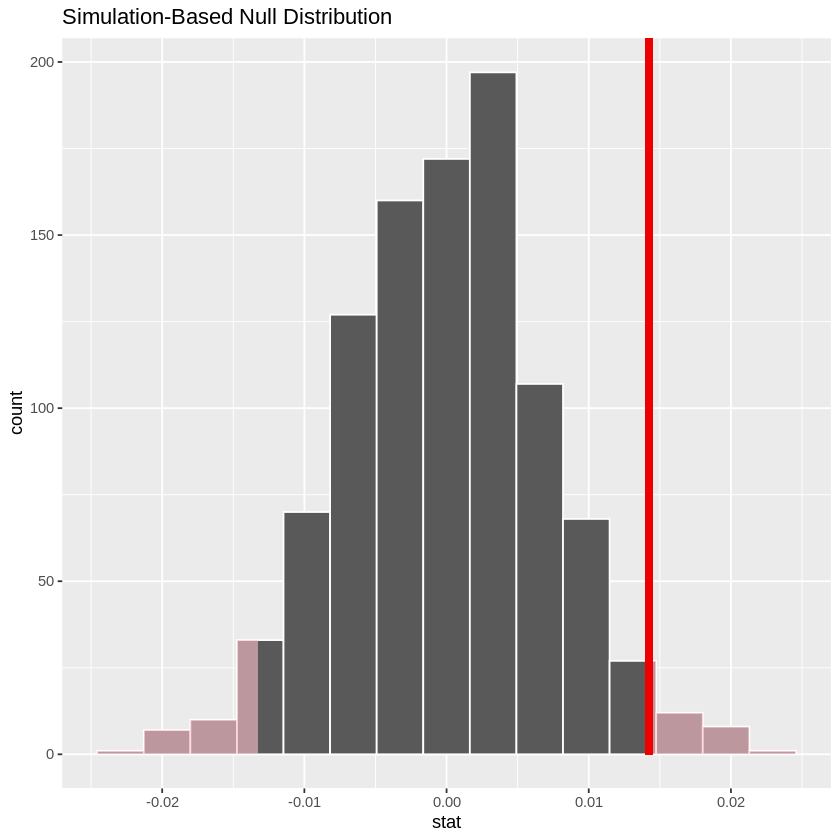

In [8]:
visualize(null_model)+
shade_p_value(obs_stat = obs_diff_prop, direction = "both")

## 6. Results and Discussion:

Based on our hypothesis test conducted with a 5% significance level, we would reject $H_0$. The p-value from the test is less than 0.05 so we would reject the null. This implies that there is a real difference between the proportion of high school graduates that defaulted on their debt payments and the proportion of university graduates that defaulted. This result is what we expected based on the preliminary analysis, seeing that there was a noticeable difference between the two proportions. With the given significance level, there is a 5% chance to commit a Type I error. In this case, a Type I error would be rejecting the null hypothesis that the default rate between high school graduates and university graduates is the same, when it is in fact the same. 

The results of this report may help to answer questions about higher education and the implications it can have on future careers and debt. One could delve deeper into other causes of debt and test whether other factors have a significant impact on the likelihood of default. One such question might be whether credit limit has an effect on default rate.   


## 7. References: 
* A. (2021, May 13). Low level of education the clearest common feature behind payment defaults. Retrieved November 4, 2022, from https://phys.org/news/2021-05-clearest-common-feature-payment-defaults.html
* Chen, J. (2022, October 06). Default: What it means, what happens when you default, examples. Retrieved November 4, 2022, from https://www.investopedia.com/terms/d/default2.asp
* I-Cheng, Y. (2016, January 26). Default of credit card clients Data Set. Retrieved November 6, 2022, from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients?fbclid=IwAR1AiSuJIomfftUAKbADULpC41ErvbIACx6mpxMvLT5QEcDLGwqalbNWujU